In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

%matplotlib inline

Using TensorFlow backend.


In [2]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../../src/harmoutil.py'>

In [3]:
### Load raw data ###
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections

### Augment data ###
augmented_data = harmoutil.transpose_and_augment_data(raw_data)

data = [harmoutil.to_triads(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

chords = [ch for section in data for ch, mel in section]
melodies_by_beats = [mel for section in data for ch, mel in section]

melodies_by_notes = []
for mel in melodies_by_beats:
    melodies_by_notes.append([n for b in mel for n in b])
notes = [n for sec in melodies_by_notes for n in sec]
print(len(chords), len(melodies_by_beats), len(melodies_by_notes), len(notes))

334344 334344 334344 2209944


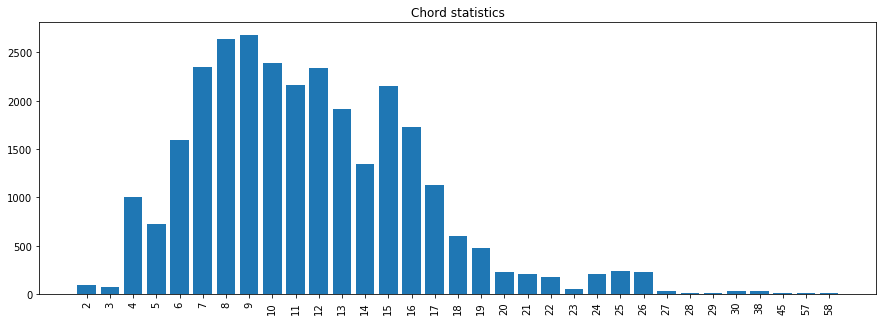

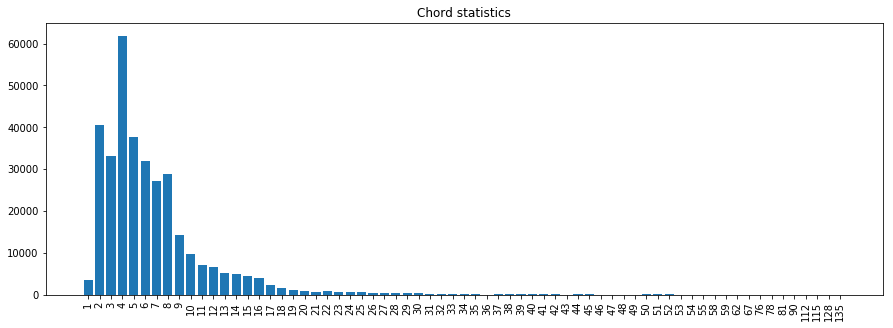

In [4]:
### Visualize classes statistics ###

chord_seq_lengths = [len(section) for section in data]

plt.clf()

labels = sorted(list(set(chord_seq_lengths)))
x_axis = range(len(labels))
y_axis = [chord_seq_lengths.count(lab) for lab in labels]

plt.figure(figsize=(15,5))
plt.bar(x_axis, y_axis, tick_label=labels)
plt.xticks(rotation='vertical')
plt.title('Chord statistics')
plt.show()


melody_seq_lengths = [len(sec) for sec in melodies_by_notes]
    
labels = sorted(list(set(melody_seq_lengths)))
x_axis = range(len(labels))
y_axis = [melody_seq_lengths.count(lab) for lab in labels]

plt.figure(figsize=(15,5))
plt.bar(x_axis, y_axis, tick_label=labels)
plt.xticks(rotation='vertical')
plt.title('Chord statistics')
plt.show()

In [5]:
### Define class integer mappings ###
notes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
notes_index[-1] = len(notes_index)
notes_index['<end>'] = len(notes_index)
notes_index['<pad>'] = len(notes_index)

index_notes = dict(
    [(v, k) for k, v in notes_index.items()])


chords_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chords_index['<bos>'] = len(chords_index)
chords_index['<eos>'] = len(chords_index)

index_chords = dict(
    [(v, k) for k, v in chords_index.items()])

In [6]:
### Numerical variables ###
n_chords = len(chords_index)
n_notes = len(notes_index)
max_melody_seq_len = max([len(mel) for mel in melodies_by_notes])
max_chords_seq_len = max([len(section) for section in data])
ch_context_window = 6


print("Total number of distinct chord labels:", n_chords)
print("Total number of distinct melody notes:", n_notes)
print("Maximum length of melody sequences:", max_melody_seq_len)
print("Maximum length of chord sequences:", max_chords_seq_len)
print("Number of chords taken into account for next prediction:", ch_context_window)

Total number of distinct chord labels: 63
Total number of distinct melody notes: 15
Maximum length of melody sequences: 135
Maximum length of chord sequences: 58
Number of chords taken into account for next prediction: 6


In [7]:
### Build tensors ###


# Build data lists
input_melody_eos = []
input_chords_eos = []
target_chords_eos = []

for section in data:
    chord_sequence = [ch for ch, mel in section]
    padded_sequence = ['<bos>']*ch_context_window + chord_sequence + ['<eos>']
    for i in range(len(chord_sequence)+1):
        input_chords_eos.append(padded_sequence[i:i+ch_context_window])
        target_chords_eos.append(padded_sequence[i+ch_context_window])

    chord_mel = [mel for ch, mel in section]
    melody_sequence = []
    for mel in chord_mel:
        ch_mel = []
        for b in mel:
            for n in b:
                ch_mel.append(n)
        melody_sequence.append(ch_mel)
    melody_sequence += [['<end>']]
    input_melody_eos += melody_sequence
    
    
# for i in range(len(data[0])+1):
#     print(input_melody[i], input_chords[i], target_chords[i])
# print(len(input_melody), len(input_chords), len(target_chords))
    
# Remove any 
print(len(target_chords_eos), len(input_chords_eos), len(input_melody_eos))
target_chords = [target_chords_eos[i] for i in range(len(target_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_chords = [input_chords_eos[i] for i in range(len(input_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_melody = [input_melody_eos[i] for i in range(len(input_melody_eos)) if not target_chords_eos[i] == '<eos>']
print(len(target_chords), len(input_chords), len(input_melody))
    
    
n_entries = len(target_chords)

X_melody = np.zeros((n_entries, max_melody_seq_len, n_notes), dtype='float32')
X_chords = np.zeros((n_entries, ch_context_window, n_chords), dtype='float32')
Y = np.zeros((n_entries, n_chords), dtype='float32')



for i, (in_mel, in_ch, tg_ch) in enumerate(zip(input_melody, input_chords, target_chords)):
    Y[i, chords_index[tg_ch]] = 1
    for j, ch in enumerate(in_ch):
        X_chords[i, j, chords_index[ch]] = 1
        
    padded_melody = in_mel + ['<pad>']*(max_melody_seq_len - len(in_mel))
    for k, note in enumerate(padded_melody):
        X_melody[i, k, notes_index[note]] = 1
            
print(int(np.sum(X_melody)), n_entries*max_melody_seq_len)
print(int(np.sum(X_chords)), n_entries*ch_context_window)
print(int(np.sum(Y)), n_entries)


363228 363228 363228
334344 334344 334344
45115280 45136440
2006064 2006064
334344 334344


In [8]:
### Train/Validation/Test sets ###
seed = 1

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in strat_split.split(X_chords, Y):
    X_melody_train = X_melody[train_index]
    X_chords_train = X_chords[train_index]
    Y_train = Y[train_index]
    
    X_melody_aux = X_melody[aux_index]
    X_chords_aux = X_chords[aux_index]
    Y_aux = Y[aux_index]
    
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
for valid_index, test_index in strat_split.split(X_chords_aux, Y_aux):
    X_melody_valid = X_melody_aux[valid_index]
    X_chords_valid = X_chords_aux[valid_index]
    Y_valid = Y_aux[valid_index]
    
    X_melody_test = X_melody_aux[test_index]
    X_chords_test = X_chords_aux[test_index]
    Y_test = Y_aux[test_index]

print(X_melody_train.shape, X_chords_train.shape, Y_train.shape)
print(X_melody_valid.shape, X_chords_valid.shape, Y_valid.shape)
print(X_melody_test.shape, X_chords_test.shape, Y_test.shape)

# train_size = melody_train.shape[0]
# test_size = melody_test.shape[0]

(267475, 135, 15) (267475, 6, 63) (267475, 63)
(33434, 135, 15) (33434, 6, 63) (33434, 63)
(33435, 135, 15) (33435, 6, 63) (33435, 63)


In [9]:
### Define neural net architectur ###
latent_dim = 128

melody_input = Input(shape=(max_melody_seq_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

chords_input = Input(shape=(ch_context_window, n_chords))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru, chords_gru])

chord_dense = Dense(n_chords, activation='softmax')(concat)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 135, 15)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 6, 63)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           55296       input_1[0][0]                    
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 128)           73728       input_2[0][0]                    
___________________________________________________________________________________________

In [10]:
### Introduce Early-Stopping and Save Best Performance callbacks ###
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "../../models/triad_cc-6.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [11]:
### Train model ###
batch_size = 32
epochs = 50

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[es, bp])

Train on 267475 samples, validate on 33434 samples
Epoch 1/50
267475/267475 [==============================] - 1284s - loss: 2.1568 - acc: 0.4453 - val_loss: 1.8877 - val_acc: 0.5010
Epoch 2/50
267475/267475 [==============================] - 1291s - loss: 1.7315 - acc: 0.5397 - val_loss: 1.6530 - val_acc: 0.5561
Epoch 3/50
267475/267475 [==============================] - 1297s - loss: 1.5246 - acc: 0.5897 - val_loss: 1.5122 - val_acc: 0.5943
Epoch 4/50
267475/267475 [==============================] - 1302s - loss: 1.3928 - acc: 0.6215 - val_loss: 1.4282 - val_acc: 0.6177
Epoch 5/50
267475/267475 [==============================] - 1305s - loss: 1.2997 - acc: 0.6446 - val_loss: 1.3677 - val_acc: 0.6355
Epoch 6/50
267475/267475 [==============================] - 1280s - loss: 1.2299 - acc: 0.6626 - val_loss: 1.3274 - val_acc: 0.6444
Epoch 7/50
267475/267475 [==============================] - 1282s - loss: 1.1742 - acc: 0.6750 - val_loss: 1.3006 - val_acc: 0.6530
Epoch 8/50
267475/267475 

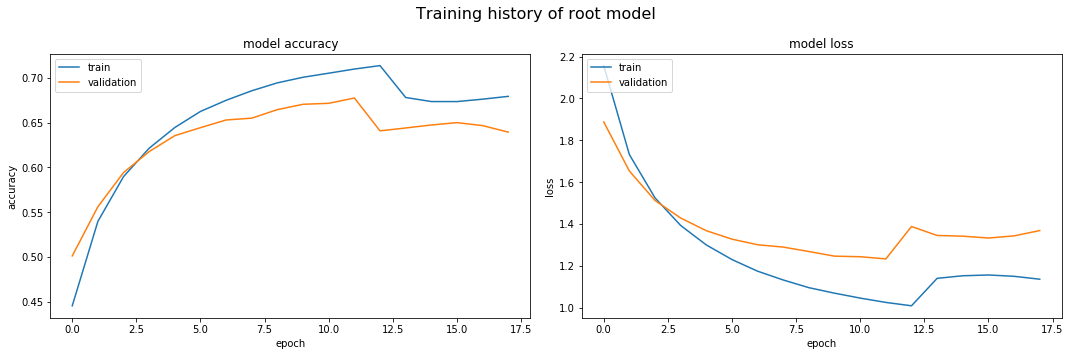

In [12]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [13]:
### Load best performance model ###
model = load_model("../../models/triad_cc-6.h5")

In [14]:
### Evaluate predictions ###

# Predict chords from each test sample melody
chord_pred = model.predict([X_melody_test, X_chords_test])

    
# Compute accuracy and kappa score 
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_test, chord_pred)))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_test, chord_pred)))

Categorical accuracy of combined chord prediction: 0.6777
Kappa score of combined chord prediction: 0.6617


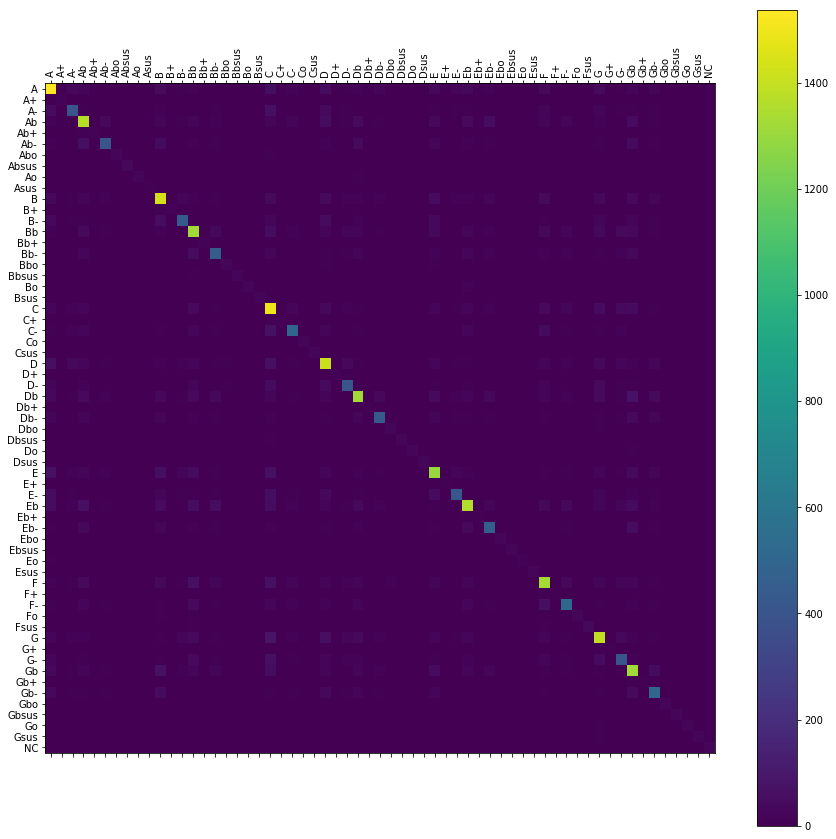

In [15]:
### Visualize prediction ###
chord_test_labels = [index_chords[np.argmax(row)] for row in Y_test]
chord_pred_labels = [index_chords[np.argmax(row)] for row in chord_pred]

chord_cm = confusion_matrix(chord_test_labels, chord_pred_labels)

labels = sorted(list(set(chord_test_labels)))
# print(labels)
plt.figure(figsize=(15,15))              
ax = plt.axes()                 
im = ax.matshow(chord_cm)      
plt.colorbar(im, ax=ax)               
plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
plt.yticks(np.arange(len(labels)), labels)
plt.show()
